In [57]:
from datetime import datetime
import numpy as np
import torch
import argparse
import torch.optim as optim
import torch.nn.functional as F
import sys
import matplotlib.pyplot as plt
sys.path.append("../../")
from TCN.soil_classification.model import TCN
from TCN.soil_classification.utils import data_generator, data_generator_test
from torch.autograd import Variable
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from numpy.random import default_rng

In [58]:
train_folder = "/home/mads/git/TCN/TCN/soil_classification/data/exp_1604/train"
test_folder = "/home/mads/git/TCN/TCN/soil_classification/data/exp_1604/test"
X_train, Y_train = data_generator(train_folder, 100, 99, None)
X_test, Y_test, plotting, files = data_generator_test(test_folder, 100, 99, None)

mins, _ = torch.min(torch.min(X_train,1)[0],0)
maxs, _ = torch.max(torch.max(X_train,1)[0],0)
X_train = (X_train-mins)/(maxs-mins)
for traj_idx in range(len(X_test)):
    X_test[traj_idx] = (X_test[traj_idx]-mins)/(maxs-mins)
    X_test[traj_idx] = X_test[traj_idx].permute(0,2,1)
X_train = X_train.permute(0,2,1)
print(X_test[0].shape)
print(X_train.shape)

torch.Size([1504, 17, 100])
torch.Size([54124, 17, 100])


In [59]:
print(files)

['exp1604_downsample_08.csv', 'exp1604_downsample_10.csv', 'exp1604_downsample_15.csv', 'exp1604_downsample_19.csv', 'exp1604_downsample_22.csv', 'exp1604_downsample_31.csv', 'exp1604_downsample_35.csv', 'exp1604_downsample_37.csv']


In [64]:
rng = default_rng()
output = []
for y in Y_test:
    output_ = y+0.25*rng.standard_normal(y.shape[0])
    output.append(np.round(output_))
print(output)
torch.cat(Y_test)

[tensor([1., 1., 1.,  ..., 1., 1., 1.], dtype=torch.float64), tensor([1., 2., 0.,  ..., 1., 1., 1.], dtype=torch.float64), tensor([3., 3., 3.,  ..., 3., 2., 2.], dtype=torch.float64), tensor([3., 3., 3.,  ..., 3., 3., 3.], dtype=torch.float64), tensor([2., 2., 2.,  ..., 2., 2., 2.], dtype=torch.float64), tensor([2., 2., 2.,  ..., 2., 2., 2.], dtype=torch.float64), tensor([ 0., -0.,  0.,  ...,  0., -0., -1.], dtype=torch.float64), tensor([0., -0., -0.,  ..., 0., 1., 0.], dtype=torch.float64)]


tensor([1, 1, 1,  ..., 0, 0, 0])

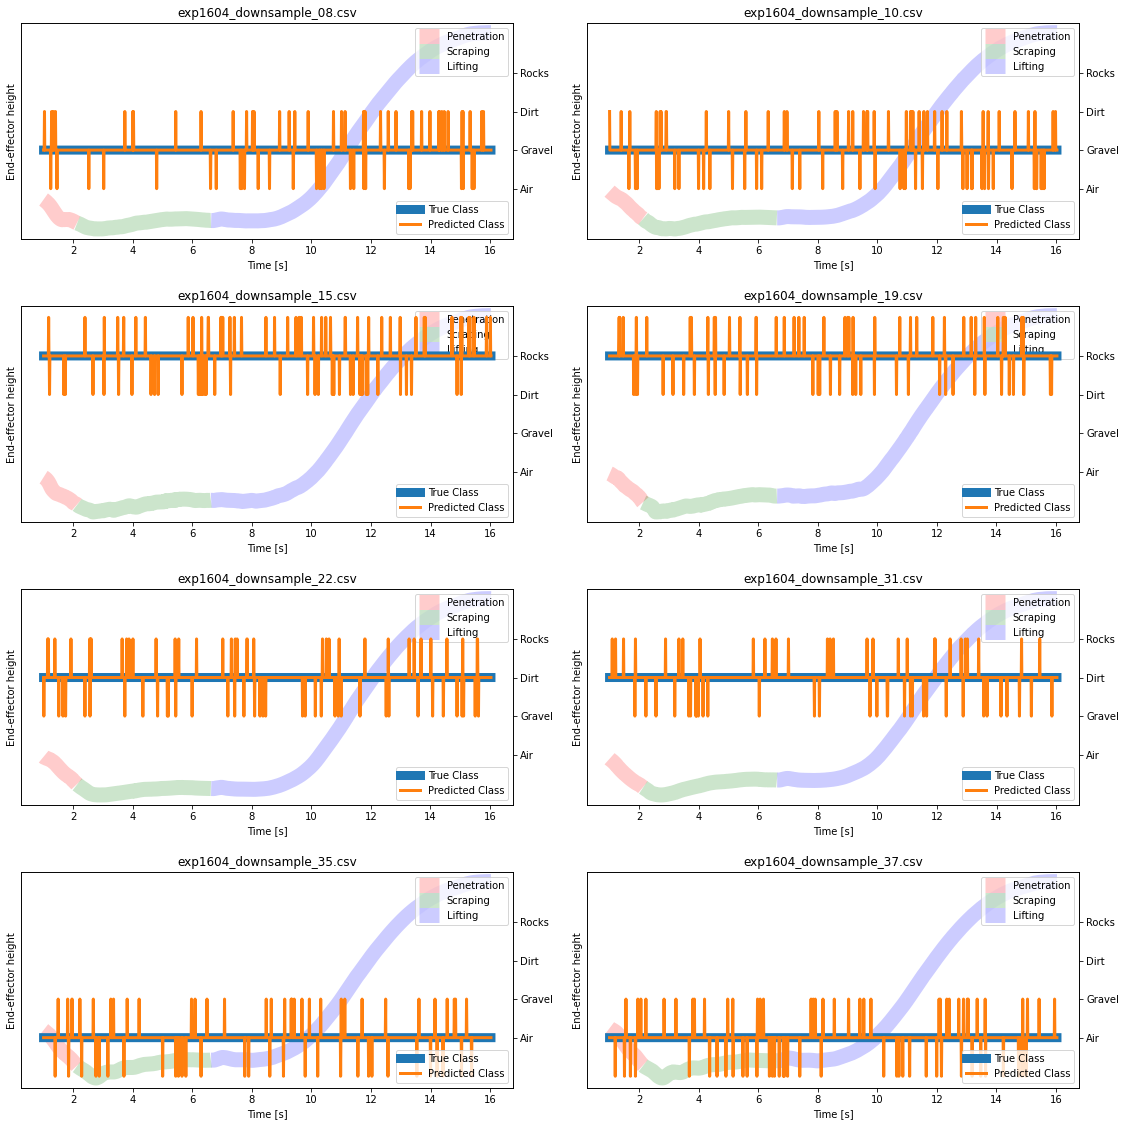

In [62]:
rows = int((len(plotting)+1)/2)

colors = ["r","g","b"]
yticks = ['Air','Gravel','Dirt','Rocks']
y_nums = np.array([0,1,2,3])
phases = ["Penetration", "Scraping", "Lifting"]

fig, ax1 = plt.subplots(rows,2,figsize = [16,4*rows])
ax2 = np.empty_like(ax1)
for a1,a2,d,f,y,out in zip(ax1.reshape(-1),ax2.reshape(-1),plotting,files, Y_test,output):
    a2 = a1.twinx()
    a1.title.set_text(f)
    #a1.set_ylim([-1, 4])
    a2.set_ylim([-1.3, 4.3])
    plt.yticks(y_nums,yticks)
    a1.axes.get_yaxis().set_ticks([])
    a1.set_xlabel("Time [s]")
    a1.set_ylabel("End-effector height")
    
    for phase in np.unique(d[:,-1]):
        a1.plot(d[d[:,-1]==phase,0],d[d[:,-1]==phase,2],color=colors[int(phase)-1],
                      linewidth=15, alpha=0.2, label = phases[int(phase)-1], solid_capstyle='butt')
        
    a2.plot(d[:,0],y, linewidth=9, label="True Class")
    a2.plot(d[:,0],out, linewidth=3, label="Predicted Class")
    a1.legend(loc=1)
    a2.legend(loc=4)
fig.tight_layout(pad=2.0)
plt.savefig("test.pdf", dpi=150)